In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd

print(tf.__version__)

2.3.0


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence_english(w):
    w = unicode_to_ascii(w.lower().strip())

    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w
  
def preprocess_sentence_hindi(w):
    w = unicode_to_ascii(w.strip())

    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [ ]:
import os
print(os.getcwd())
os.chdir('/content/drive/My Drive/Colab Notebooks')
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks


In [ ]:
PATH = "/content/drive/My Drive/Colab Notebooks/Hindi_English_Truncated_Corpus.csv"
data = pd.read_csv(PATH)
data.head(3)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।


In [ ]:
print(data['english_sentence'].count())
print(data['hindi_sentence'].count())

127605
127607


In [ ]:
data = data[data['english_sentence'].map(type) == str]
data = data[data['hindi_sentence'].map(type) == str]
data = data[data['english_sentence'].map(len) > 0]
data = data[data['hindi_sentence'].map(len) > 0]

print(data['english_sentence'].count())
print(data['hindi_sentence'].count())

127605
127605


In [ ]:
data["token_size_en"] = data["english_sentence"].apply(lambda x: len(x.split(' ')))
data["token_size_hn"] = data["hindi_sentence"].apply(lambda x: len(x.split(' ')))

In [ ]:
data = data.loc[data['token_size_hn'] < 22].copy()

In [ ]:
data['english_sentence'] = data['english_sentence'].apply(preprocess_sentence_english)
data['hindi_sentence'] = data['hindi_sentence'].apply(preprocess_sentence_hindi)

In [ ]:
data.head()

,source,english_sentence,hindi_sentence,token_size_en,token_size_hn
0,ted,<start> politicians do not have permission to ...,"<start> राजनीतिजञो क पास जो कारय करना चाहिए , ...",12,14
1,ted,<start> i d like to tell you about one such ch...,<start> मई आपको ऐस ही एक बचच क बार म बताना चाह...,9,11
2,indic2012,<start> this percentage is even greater than t...,<start> यह परतिशत भारत म हिनदओ परतिशत स अधिक ह...,10,9
3,ted,<start> what we really mean is that they re ba...,<start> हम य नही कहना चाहत कि वो धयान नही द पा...,12,11
4,indic2012,<start> . the ending portion of these vedas is...,<start> इनही वदो का अतिम भाग उपनिषद कहलाता ह। ...,9,8


In [ ]:
en = data['english_sentence'].values.tolist()
hn = data['hindi_sentence'].values.tolist()

In [ ]:
len(en),len(hn)

(90799, 90799)

In [ ]:
en[-1],hn[-1]

('<start> they ve just won four government contracts to build off their ambulances , <end>',
 '<start> हाल ही म उनह सरकारी ठका मिला ह करीब सौ नई अमबलनस बनान का , <end>')

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(num_examples):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = data['hindi_sentence'].values.tolist()[:num_examples],data['english_sentence'].values.tolist()[:num_examples]

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(35000)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [ ]:
print(max_length_inp,max_length_targ)
print(len(input_tensor),target_tensor[:2])

48 31
35000 [[   1 7745    4  109   29  197   92  106    7   52   36   16 1806   19
     3    5    2    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   1 1404  112  176   23   14  217    4   51    6 1129 2600    7    2
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]]


In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

28000 28000 7000 7000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
2932 ----> technical
2013 ----> note
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
2294 ----> तकनीकी
3792 ----> नोट
2 ----> <end>


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 48]), TensorShape([64, 31]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 48, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention?version=nightly

In [ ]:
class LuongAttention(tf.keras.Model):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.Wa = tf.keras.layers.Dense(units)

  def call(self, query, values):
    self.Wa = tf.keras.layers.Dense(units)
    score1 = self.Wa(query)
    #print(score1.shape)
    #print(values.shape)
    query_with_time_axis = tf.expand_dims(score1, 1)
    score = query_with_time_axis * values
    score = tf.reduce_sum(score, axis=2)
    score = tf.expand_dims(score, 2)
    
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # self.wa = tf.keras.layers.Dense(256)
    # score = tf.matmul(query, self.wa(
    #              values), transpose_b=True)
    #attention_weights = tf.nn.softmax(score, axis=2)

    #     # context vector c_t is the weighted average sum of encoder output
    #context_vector = tf.matmul(attention_weights, values)

    return context_vector, attention_weights
    















    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    #query_with_time_axis = tf.expand_dims(query, 1)

    # inner product, score shape == (batch_size, max_length, 1)
    # print(query_with_time_axis.shape)
    # print(values.shape)
    # score = query_with_time_axis * values 
    # score = tf.reduce_sum(score, axis=2)
    # score = tf.expand_dims(score, 2)
    
    # # attention_weights shape == (batch_size, max_length, 1)
    # attention_weights = tf.nn.softmax(score, axis=1)

    # # context_vector shape after sum == (batch_size, hidden_size)
    # context_vector = attention_weights * values
    # context_vector = tf.reduce_sum(context_vector, axis=1)

    # return context_vector, attention_weights


    ###########################################################
    # def __init__(self,units):
    #     super(LuongAttention, self).__init__()
    #     self.wa = tf.keras.layers.Dense(units)



       # if attention_func == 'general':
            # General score function

        # elif attention_func == 'concat':
        #     # Concat score function
        #     self.wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
        #     self.va = tf.keras.layers.Dense(1)

    # def call(self, query, values):
    #     self.wa = tf.keras.layers.Dense(1024)

    #     query_with_time_axis = tf.expand_dims(query, 1)
    #     print(query_with_time_axis.shape)
    #     score = tf.matmul(query, self.wa(
    #             values), transpose_b=True)
    #     #score = 
    #     print(score)
        
    #     # alignment a_t = softmax(score)
    #     attention_weights = tf.nn.softmax(score, axis=2)

    #     # context vector c_t is the weighted average sum of encoder output
    #     context_vector = tf.matmul(attention_weights, values)

    #     return context_vector, attention_weights

#################################################################################

    #     def call(self, query, values):
    # # query hidden state shape == (batch_size, hidden size)
    # # query_with_time_axis shape == (batch_size, 1, hidden size)
    # # values shape == (batch_size, max_len, hidden size)
    # # we are doing this to broadcast addition along the time axis to calculate the score
    # query_with_time_axis = tf.expand_dims(query, 1)

    # # inner product, score shape == (batch_size, max_length, 1)
    # score = query_with_time_axis * values
    # score = tf.reduce_sum(score, axis=2)
    # score = tf.expand_dims(score, 2)
    
    # # attention_weights shape == (batch_size, max_length, 1)
    # attention_weights = tf.nn.softmax(score, axis=1)

    # # context_vector shape after sum == (batch_size, hidden_size)
    # context_vector = attention_weights * values
    # context_vector = tf.reduce_sum(context_vector, axis=1)

    # return context_vector, attention_weights




    # def __init__(self, rnn_size, attention_func):
    #     super(LuongAttention, self).__init__()
    #     self.attention_func = attention_func

    #     if attention_func not in ['dot', 'general', 'concat']:
    #         raise ValueError(
    #             'Unknown attention score function! Must be either dot, general or concat.')

    #     if attention_func == 'general':
    #         # General score function
    #         self.wa = tf.keras.layers.Dense(rnn_size)
    #     elif attention_func == 'concat':
    #         # Concat score function
    #         self.wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
    #         self.va = tf.keras.layers.Dense(1)

    # def call(self, decoder_output, encoder_output):
    #     if self.attention_func == 'dot':
    #         # Dot score function: decoder_output (dot) encoder_output
    #         # decoder_output has shape: (batch_size, 1, rnn_size)
    #         # encoder_output has shape: (batch_size, max_len, rnn_size)
    #         # => score has shape: (batch_size, 1, max_len)
    #         score = tf.matmul(decoder_output, encoder_output, transpose_b=True)
    #     elif self.attention_func == 'general':
    #         # General score function: decoder_output (dot) (Wa (dot) encoder_output)
    #         # decoder_output has shape: (batch_size, 1, rnn_size)
    #         # encoder_output has shape: (batch_size, max_len, rnn_size)
    #         # => score has shape: (batch_size, 1, max_len)
    #         score = tf.matmul(decoder_output, self.wa(
    #             encoder_output), transpose_b=True)
    #     elif self.attention_func == 'concat':
    #         # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
    #         # Decoder output must be broadcasted to encoder output's shape first
    #         decoder_output = tf.tile(
    #             decoder_output, [1, encoder_output.shape[1], 1])

    #         # Concat => Wa => va
    #         # (batch_size, max_len, 2 * rnn_size) => (batch_size, max_len, rnn_size) => (batch_size, max_len, 1)
    #         score = self.va(
    #             self.wa(tf.concat((decoder_output, encoder_output), axis=-1)))

    #         # Transpose score vector to have the same shape as other two above
    #         # (batch_size, max_len, 1) => (batch_size, 1, max_len)
    #         score = tf.transpose(score, [0, 2, 1])

    #     # alignment a_t = softmax(score)
    #     alignment = tf.nn.softmax(score, axis=2)

    #     # context vector c_t is the weighted average sum of encoder output
    #     context = tf.matmul(alignment, encoder_output)

    #     return context, alignment

In [ ]:
attention_layer = LuongAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 48, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = LuongAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 27722)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
#@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.0116
Epoch 1 Batch 100 Loss 2.8261
Epoch 1 Batch 200 Loss 2.4319
Epoch 1 Batch 300 Loss 2.3760
Epoch 1 Batch 400 Loss 2.4044
Epoch 1 Loss 2.5772
Time taken for 1 epoch 293.792986869812 sec

Epoch 2 Batch 0 Loss 2.1356
Epoch 2 Batch 100 Loss 2.2390
Epoch 2 Batch 200 Loss 2.4158
Epoch 2 Batch 300 Loss 2.4533
Epoch 2 Batch 400 Loss 2.2619
Epoch 2 Loss 2.2625
Time taken for 1 epoch 292.53888177871704 sec

Epoch 3 Batch 0 Loss 2.3400


ResourceExhaustedError: ignored

I got OOM error after 2 or 3 epochs but it sometimes ran for 3-4 epochs and then gave this error , so i proceeded with less training.

In [ ]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence_english(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> home <end>
Predicted translation: यह <end> 


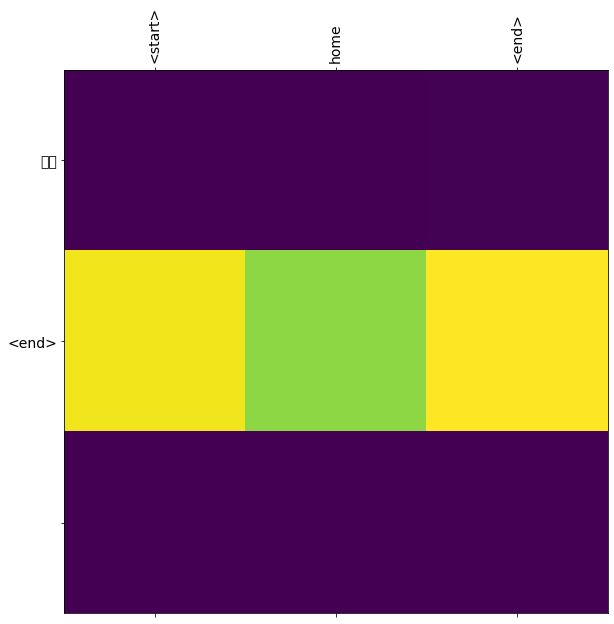

In [ ]:
translate('home')

Input: <start> phone <end>
Predicted translation: (हसी) <end> 


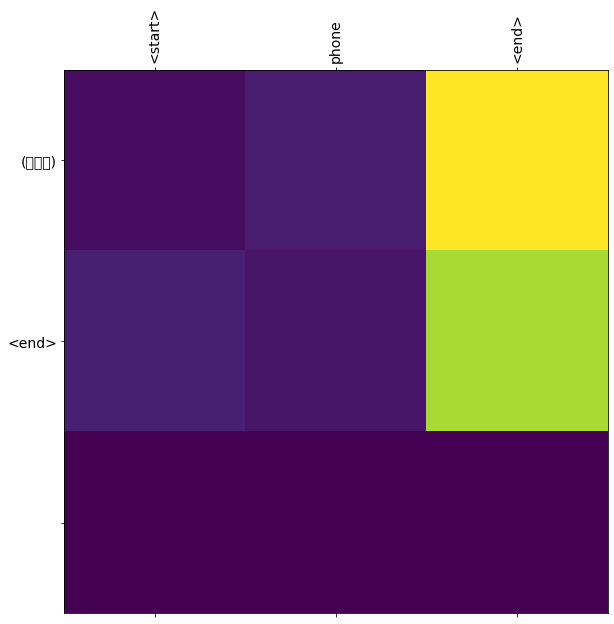

In [ ]:
translate(' phone')

Input: <start> door <end>
Predicted translation: और इस परकार <end> 


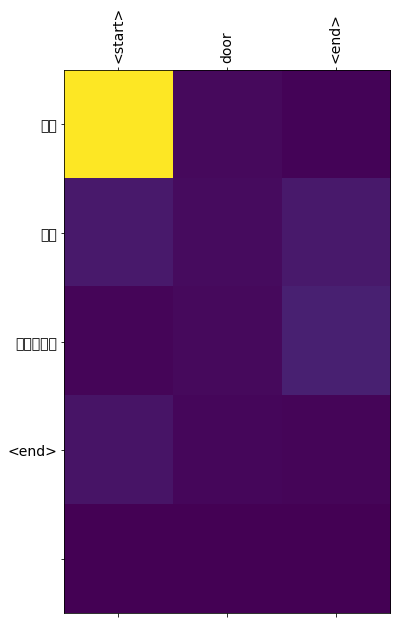

In [ ]:
translate('door')

**Questions and answers**

1. Do you see qualitative differences in the attention weights between different attention mechanisms?
  
  Ans: The model's performance is almost same but there is quantitative difference between attention weights. Attention weights are calculated by applying softmax on attention score which is calculated differently in all the three methods. We used 3 additional weight parameters while calculating scores in Bahdanau , 2 in Luong and no additional weights in dot product ateention mechanism.

2. Do you think that the model attends to the correct tokens in the input language? (if you understand both languages)

  Ans: In Bahdanau and dot product the model did attend to correct tokens but in case of luong it did not gave me correct results. It could be because of the less training due to OOM error which I frequently got during training.

3. Which parts of the sentence are used as a token? Each character, each word, or are some words split up?

  Ans: Punctuations are removed from the sequence and after that each word is considered as a token and is mapped to an ID. 

4. Do the same tokens in different language have the same ID?

  Ans: No the same tokens in differnt laguages do not have same ID as the come from different dictionaries.

5. What is the relation between the encoder output and the encoder hidden state which is used to initialize the decoder hidden state?
(for the architecture used in the tutorial)

  Ans: The encoder outputs are discarded and only the hidden or internal states are passed as initial inputs to the decoder.

6. Is the decoder attending to all previous positions, including the previous decoder predictions?

  Ans: During training it gets input from previous timestamps.
During the inference phase, we pass the predicted output from the previous time step as the input to the decoder along with the hidden states.

7. Does the Encoder output change in different decoding steps?

  Ans: No, the encoder output does not change in different decoding steps. 

8. Does the context vector change in different decoding steps?

  Ans: yes with help of weights in decoding steps.

9. The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel?

  Ans: Teacher forcing algorithm trains decoder by supplying actual output of the previous timestamp instead of the predicted output from the previous time as inputs during training. So, it depends on previous timestamps and hence i don't think paralleisation is possible.

10. Why is a mask applied to the loss function?

  Ans: This I didn't understand. :(
